In [217]:
import warnings
warnings.simplefilter('ignore')
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split as tts,cross_val_score,ShuffleSplit
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score,f1_score,classification_report,roc_auc_score
pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows',None)
from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly_express as px

ModuleNotFoundError: No module named 'plotly_express'

In [565]:
df=pd.read_csv("Final_invoice.csv")
df = df.rename(columns={'Total Amt Wtd Tax.':'Total_Expense'})

In [566]:
df.head(2)

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2


In [567]:
import pgeocode
nomi = pgeocode.Nominatim('IN')


In [568]:
df["City"]=nomi.query_postal_code(np.array(df["Pin code"].astype(str))).county_name

# Data_Finalinvoice["updated_District"]=nomi.query_postal_code(np.array(Data_Finalinvoice["Pin code"].astype(str))).state_name
# Data_Finalinvoice["updated_Location_Area"]=nomi.query_postal_code(np.array(Data_Finalinvoice["Pin code"].astype(str))).place_name

In [569]:
df["Invoice_DateTime"]=df["Invoice Date"]+' '+df["Invoice Time"]
df["JobCard_DateTime"]=df["JobCard Date"]+' '+df["JobCard Time"]
df['JobCard_DateTime'] = pd.to_datetime(df['JobCard_DateTime'],dayfirst=True)
df['Invoice_DateTime'] = pd.to_datetime(df['Invoice_DateTime'],dayfirst=True)
df["Service_Time"]=df["Invoice_DateTime"]-df["JobCard_DateTime"]

In [570]:
df["Invoice_DateTime"] = pd.to_datetime(df["Invoice_DateTime"])
df["JobCard_DateTime"] = pd.to_datetime(df["JobCard_DateTime"])
df['Job_duration(in hrs)']=(df['Invoice_DateTime'] -df['JobCard_DateTime']).astype('timedelta64[h]')

In [571]:
df["Year"] = pd.DatetimeIndex(df["JobCard_DateTime"]).year

In [572]:
df["month"] = pd.DatetimeIndex(df["JobCard_DateTime"]).month

In [573]:
df.head()

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,City,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1,Thane,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,477.0,2014,12
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2,Thane,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,19.0,2015,1
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2,Thane,2015-01-03 11:12:57,2015-01-02 11:40:44,0 days 23:32:13,23.0,2015,1
3,3,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,0.00,0.0,0.0,0.0,0.0,0.00,BC01SA2,Thane,2015-01-03 11:40:44,2015-01-03 10:12:32,0 days 01:28:12,1.0,2015,1
4,4,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NaN,NO,0.0,MH04CD9768,0.0,0.0,0.0,0.0,NaN,0.0,DAYANAND,2747.12,0.0,0.0,0.0,0.0,2747.12,BC01SA2,Thane,2015-01-03 12:07:17,2015-01-02 10:45:42,1 days 01:21:35,25.0,2015,1


In [574]:
df[df['Job_duration(in hrs)']<0]

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,City,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month
359015,794156,NaN,NaN,PUDUPAKKAM,NaN,NaN,NaN,NaN,CHENNAI,NaN,NaN,Retail,182085,Tamil Nadu,NaN,NaN,00:00:00,NaN,NaN,NaN,NaN,NaN,2016-05-02,7167000988,15:12:11,363294,2016-05-02,15:12:44,62001,0.0,MARUTI SUZUKI,0.0,SWIFT DZIRE,NaN,0.0,Running Repairs,NaN,0.0,603103,X085,X085 - SRI MOTORS,NaN,NO,0.0,TN19M6594,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,X085SA1,Kanchipuram,2016-05-02 15:12:11,2016-05-02 15:12:44,-1 days +23:59:27,-1.0,2016,5


In [575]:
# df.drop(index=359015,axis=0,inplace=True)

In [576]:
df.Year.value_counts()

2016    196156
2015    125393
2014     95777
2013     56240
2012     18748
Name: Year, dtype: int64

In [577]:
# df.columns

In [578]:
df.shape

(492314, 66)

In [579]:
len(df['Customer No.'].unique())

253484

In [580]:
df.Year.value_counts()

2016    196156
2015    125393
2014     95777
2013     56240
2012     18748
Name: Year, dtype: int64

In [581]:
year_16=df[df["Year"]==2016]

In [582]:
year_16.drop(["Unnamed: 0"],1,inplace=True)

In [583]:
year_16.head(2)

,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,City,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month
295028,NaN,NaN,MUMBAI,NaN,NaN,NaN,NaN,BHANDUP,NaN,NaN,Retail,119371,Maharashtra,NaN,2016-01-02 00:00:00,15:41:33,NaN,NaN,NaN,NaN,NaN,2016-01-02,7005202789,11:27:27,300412,2016-01-02,10:52:24,35654,1125.76,MARUTI SUZUKI,291.45,ZEN ESTILO,NaN,0.0,SMC Value Package,NaN,2082.07,400089,BC01,THANE,NaN,YES,0.0,MH02BD6668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3499.28,NaN,NaN,NaN,NaN,NaN,BC01SA2,Mumbai,2016-01-02 11:27:27,2016-01-02 10:52:24,0 days 00:35:03,0.0,2016,1
295029,NaN,NaN,THNAE,NaN,NaN,NaN,NaN,THANE,NaN,NaN,Retail,128929,Maharashtra,NaN,2016-01-02 00:00:00,13:05:33,NaN,NaN,NaN,NaN,NaN,2016-01-02,7005202790,13:03:16,300447,2016-01-02,11:50:58,70730,233.85,MARUTI SUZUKI,0.00,SWIFT,NaN,0.0,Running Repairs,NaN,195.44,400604,BC01,THANE,NaN,YES,0.0,MH12EM2307,NaN,NaN,NaN,NaN,NaN,NaN,NaN,429.29,NaN,NaN,NaN,NaN,NaN,BC01SA2,Thane,2016-01-02 13:03:16,2016-01-02 11:50:58,0 days 01:12:18,1.0,2016,1


In [584]:
year_16.columns

Index(['Amt Rcvd From Custom', 'Amt Rcvd From Ins Co', 'Area / Locality',
       'CGST(14%)', 'CGST(2.5%)', 'CGST(6%)', 'CGST(9%)', 'CITY',
       'Cash /Cashless Type', 'Claim No.', 'Cust Type', 'Customer No.',
       'District', 'Expiry Date', 'Gate Pass Date', 'Gate Pass Time',
       'IGST(12%)', 'IGST(18%)', 'IGST(28%)', 'IGST(5%)', 'Insurance Company',
       'Invoice Date', 'Invoice No', 'Invoice Time', 'Job Card No',
       'JobCard Date', 'JobCard Time', 'KMs Reading', 'Labour Total', 'Make',
       'Misc Total', 'Model', 'ODN No.', 'OSL Total', 'Order Type',
       'Outstanding Amt', 'Parts Total', 'Pin code', 'Plant', 'Plant Name1',
       'Policy no.', 'Print Status', 'Recovrbl Exp', 'Regn No',
       'SGST/UGST(14%)', 'SGST/UGST(2.5%)', 'SGST/UGST(6%)', 'SGST/UGST(9%)',
       'Service Advisor Name', 'TDS amount', 'Technician Name',
       'Total_Expense', 'Total CGST', 'Total GST', 'Total IGST',
       'Total SGST/UGST', 'Total Value', 'User ID', 'City', 'Invoice_DateTime

In [585]:
# Calculating frequency of visits & total revenue of a customer for calculation of ltv

customer_freq=year_16.groupby(["Make","Model","City","Customer No."]).agg({"Invoice No":'nunique',"Total_Expense":'mean',"Job_duration(in hrs)":'mean'})
customer_freq=customer_freq.reset_index()

customer_freq.head(10)

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs)
0,AUDI,A4,Bengaluru,197826,1,0.00,839.000000
1,AUDI,A4,Chennai,251998,1,131637.61,359.000000
2,AUDI,A4,East Godavari,182988,2,479.38,12.500000
3,AUDI,A4,East Godavari,243916,1,1478.30,4.000000
4,AUDI,A4,Firozpur,89967,2,3493.44,24.500000
5,AUDI,A4,Ghaziabad,141369,1,248.89,1.000000
6,AUDI,A4,Indore,158521,3,23460.48,30.666667
7,AUDI,A4,Indore,238765,2,34493.22,145.000000
8,AUDI,A4,Khorda,259799,1,330.50,0.000000
9,AUDI,A4,Kolhapur,83636,2,1125.25,10.500000


In [586]:
ltv_make_model_r=customer_freq.copy()
ltv_make_model_r["LTV"] = ltv_make_model_r['Invoice No'] * ltv_make_model_r["Total_Expense"]
ltv_make_model_r.head()

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs),LTV
0,AUDI,A4,Bengaluru,197826,1,0.00,839.0,0.00
1,AUDI,A4,Chennai,251998,1,131637.61,359.0,131637.61
2,AUDI,A4,East Godavari,182988,2,479.38,12.5,958.76
3,AUDI,A4,East Godavari,243916,1,1478.30,4.0,1478.30
4,AUDI,A4,Firozpur,89967,2,3493.44,24.5,6986.88


# Filtering customer having LTV/Total revenue > 0

In [587]:
ltv_make_model_r = ltv_make_model_r[ltv_make_model_r['LTV'] > 0]

In [588]:
ltv_make_model_r.shape

(113686, 8)

In [589]:
print("0.05 quantile :-",ltv_make_model_r['LTV'].quantile(0.05))
print("0.25 quantile :-",ltv_make_model_r['LTV'].quantile(0.25))
print("0.50 quantile :-",ltv_make_model_r['LTV'].quantile(0.50))
print("0.75 quantile :-",ltv_make_model_r['LTV'].quantile(0.75))
print("0.95 quantile :-",ltv_make_model_r['LTV'].quantile(0.95))
print("minimum LTV :-",ltv_make_model_r['LTV'].min())
print("maximum LTV :-",ltv_make_model_r['LTV'].max())
print("mean LTV :-",ltv_make_model_r['LTV'].mean())

0.05 quantile :- 99.14
0.25 quantile :- 449.75
0.50 quantile :- 2204.23
0.75 quantile :- 6278.9925
0.95 quantile :- 26696.415
minimum LTV :- 0.01
maximum LTV :- 1375024.6900000004
mean LTV :- 6645.426823442873


In [590]:
# Low revenue customers (less than 0.50 quantile)
low_ltv = ltv_make_model_r[(ltv_make_model_r['LTV']< ltv_make_model_r['LTV'].quantile(0.50))]

# Medium revenue customers (between 0.50 to 0.75 quantile)
medium_ltv = ltv_make_model_r[
                            (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.50)) & 
                            (ltv_make_model_r['LTV']< ltv_make_model_r['LTV'].quantile(0.75))
                         ]


# Average revenue customers (between 0.75 to 0.95 quantile)
avg_ltv = ltv_make_model_r[
                        (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.75)) & 
                        (ltv_make_model_r['LTV'] < ltv_make_model_r['LTV'].quantile(0.95))
                      ]


# High revenue customers (moe than 0.95 quantile)
high_ltv = ltv_make_model_r[
                        (ltv_make_model_r['LTV'] > ltv_make_model_r['LTV'].quantile(0.95))
                       ]

In [591]:
print("low_ltv",low_ltv.shape)
print("medium_ltv",medium_ltv.shape)
print("avg_ltv",avg_ltv.shape)
print("high_ltv",high_ltv.shape)

low_ltv (56843, 8)
medium_ltv (28421, 8)
avg_ltv (22737, 8)
high_ltv (5685, 8)


In [592]:
# Naming the clusters
low_ltv['LTV Category'] = 'low_ltv'
medium_ltv['LTV Category'] = 'medium_ltv'
avg_ltv['LTV Category'] = 'avg_ltv'
high_ltv['LTV Category'] = 'high_ltv'

In [593]:
ltv_make_model_r= pd.concat([low_ltv,medium_ltv,avg_ltv,high_ltv],axis=0)

In [594]:
ltv_make_model_r

,Make,Model,City,Customer No.,Invoice No,Total_Expense,Job_duration(in hrs),LTV,LTV Category
2,AUDI,A4,East Godavari,182988,2,479.380000,12.500000,958.76,low_ltv
3,AUDI,A4,East Godavari,243916,1,1478.300000,4.000000,1478.30,low_ltv
5,AUDI,A4,Ghaziabad,141369,1,248.890000,1.000000,248.89,low_ltv
8,AUDI,A4,Khorda,259799,1,330.500000,0.000000,330.50,low_ltv
10,AUDI,A4,Malappuram,201655,1,151.340000,1.000000,151.34,low_ltv
...,...,...,...,...,...,...,...,...,...
121836,VOLKSWAGEN,VENTO,Thanjavur,80445,4,10855.042500,15.000000,43420.17,high_ltv
121843,VOLKSWAGEN,VENTO,Tirunelveli,148381,4,14779.917500,597.500000,59119.67,high_ltv
121855,VOLKSWAGEN,VENTO,Tirunelveli,206379,8,6567.853750,103.375000,52542.83,high_ltv
121857,VOLKSWAGEN,VENTO,Tirunelveli,228476,3,11843.713333,210.666667,35531.14,high_ltv


In [595]:
ltv_make_model_r["LTV Category"].value_counts(dropna=False)

low_ltv       56843
medium_ltv    28421
avg_ltv       22737
high_ltv       5685
Name: LTV Category, dtype: int64

In [596]:
# Getting the number of fundings according to year
cnt_srs = ltv_make_model_r["LTV Category"].value_counts()
# sorting the years in ascending order
cnt_srs = cnt_srs.sort_index()
# setting uo the bar graph
trace = go.Bar(
    x=cnt_srs.index,
    y=cnt_srs.values,
    
)
# setting the layout
layout = go.Layout(
    title=go.layout.Title(
        text="Customer LTV Catogarization",
        x=0.5
    ),
    font=dict(size=14),
    width=800,
    height=500,
)

data = [trace]
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename="funding")

# Machine Learning

In [680]:
df.head()

,Unnamed: 0,Amt Rcvd From Custom,Amt Rcvd From Ins Co,Area / Locality,CGST(14%),CGST(2.5%),CGST(6%),CGST(9%),CITY,Cash /Cashless Type,Claim No.,Cust Type,Customer No.,District,Expiry Date,Gate Pass Date,Gate Pass Time,IGST(12%),IGST(18%),IGST(28%),IGST(5%),Insurance Company,Invoice Date,Invoice No,Invoice Time,Job Card No,JobCard Date,JobCard Time,KMs Reading,Labour Total,Make,Misc Total,Model,ODN No.,OSL Total,Order Type,Outstanding Amt,Parts Total,Pin code,Plant,Plant Name1,Policy no.,Print Status,Recovrbl Exp,Regn No,SGST/UGST(14%),SGST/UGST(2.5%),SGST/UGST(6%),SGST/UGST(9%),Service Advisor Name,TDS amount,Technician Name,Total_Expense,Total CGST,Total GST,Total IGST,Total SGST/UGST,Total Value,User ID,City,Invoice_DateTime,JobCard_DateTime,Service_Time,Job_duration(in hrs),Year,month
0,0,0.0,0.0,MAJIWADA,0.0,0.0,0.0,0.0,Thane,NaN,NaN,Retail,67849,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-02,7005200002,11:30:36,168303,2014-12-13,14:29:43,49317,1203.14,GENERAL MOTORS,0.00,SPARK,7.005200e+09,500.06,Paid Service,0.0,2348.75,400601,BC01,THANE,NaN,NO,0.0,KA19MA1291,0.0,0.0,0.0,0.0,NaN,0.0,RUPESH,4051.95,0.0,0.0,0.0,0.0,4051.95,BC01FS1,Thane,2015-01-02 11:30:36,2014-12-13 14:29:43,19 days 21:00:53,477.0,2014,12
1,1,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200003,10:07:32,173997,2015-01-02,14:12:18,78584,804.26,TATA MOTORS,197.03,INDICA,7.005200e+09,0.00,SMC Value Package,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,1001.29,0.0,0.0,0.0,0.0,1001.29,BC01SA2,Thane,2015-01-03 10:07:32,2015-01-02 14:12:18,0 days 19:55:14,19.0,2015,1
2,2,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE[W],NaN,NaN,Retail,81055,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200004,11:12:57,173889,2015-01-02,11:40:44,33985,180.19,MARUTI SUZUKI,0.00,ZEN,7.005200e+09,0.00,Running Repairs,0.0,52.95,400607,BC01,THANE,NaN,NO,0.0,AP09AX0582,0.0,0.0,0.0,0.0,NaN,0.0,IMRAN,233.14,0.0,0.0,0.0,0.0,233.14,BC01SA2,Thane,2015-01-03 11:12:57,2015-01-02 11:40:44,0 days 23:32:13,23.0,2015,1
3,3,0.0,0.0,THNAE,0.0,0.0,0.0,0.0,THNAE,NaN,NaN,Retail,84419,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200005,11:40:44,174158,2015-01-03,10:12:32,78584,0.00,TATA MOTORS,0.00,INDICA,7.005200e+09,0.00,SMC Redemption,0.0,0.00,400603,BC01,THANE,NaN,NO,0.0,MH43R3046,0.0,0.0,0.0,0.0,NaN,0.0,PRASHANT,0.00,0.0,0.0,0.0,0.0,0.00,BC01SA2,Thane,2015-01-03 11:40:44,2015-01-03 10:12:32,0 days 01:28:12,1.0,2015,1
4,4,0.0,0.0,THANE,0.0,0.0,0.0,0.0,THANE,NaN,NaN,Retail,18980,Maharashtra,NaN,NaN,00:00:00,0.0,0.0,0.0,0.0,NaN,2015-01-03,7005200006,12:07:17,173860,2015-01-02,10:45:42,50057,1202.97,HYUNDAI,100.00,SANTRO XING,7.005200e+09,499.99,Paid Service,0.0,944.16,400603,BC01,THANE,NaN,NO,0.0,MH04CD9768,0.0,0.0,0.0,0.0,NaN,0.0,DAYANAND,2747.12,0.0,0.0,0.0,0.0,2747.12,BC01SA2,Thane,2015-01-03 12:07:17,2015-01-02 10:45:42,1 days 01:21:35,25.0,2015,1


In [674]:
df2=ltv_make_model_r.copy()
df2.shape

(113686, 9)

In [611]:
le=LabelEncoder()
df2["Make"]=le.fit_transform(df2["Make"])
df2["Model"]=le.fit_transform(df2["Model"])
df2["LTV Category"]=le.fit_transform(df2["LTV Category"])
df2["City"]=le.fit_transform(df2["City"])

In [627]:
d = df2.City.value_counts(normalize=True).to_dict()
df2.City.replace(d,inplace=True)

In [626]:
X=df2.drop(["Customer No.","LTV","LTV Category","Invoice No"],1)
y=df2["LTV Category"]

In [614]:
X.head()

,Make,Model,City,Total_Expense,Job_duration(in hrs)
2,0,8,0.009561,479.38,12.5
3,0,8,0.009561,1478.30,4.0
5,0,8,0.006588,248.89,1.0
8,0,8,0.004996,330.50,0.0
10,0,8,0.005893,151.34,1.0


In [615]:
y

2         2
3         2
5         2
8         2
10        2
         ..
121836    1
121843    1
121855    1
121857    1
121889    1
Name: LTV Category, Length: 113686, dtype: int32

In [616]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

# Logistic Regression

In [681]:
lr = LogisticRegression(random_state=0).fit(X_train,y_train)

y_pred_lr = lr.predict(X_test)
y_pred_lr_train = lr.predict(X_train)

print(classification_report(X_train,y_train))
print(classification_report(y_test,y_pred_lr))

ValueError: Unknown label type: 'continuous'

In [618]:
print("Training Accuracy:-" , accuracy_score(y_test,y_pred_lr))
print("Testing Accuracy:-" ,accuracy_score(y_train,y_pred_lr_train))
print("Label Encoding")

Training Accuracy:- 0.6765378525772592
Testing Accuracy:- 0.6750188489570244
Label Encoding


# Decision Tree Classifier

In [619]:
dt = DecisionTreeClassifier(criterion='entropy',max_depth=3,random_state=0)
dt.fit(X_train,y_train)
y_pred_dt = dt.predict(X_test)
y_pred_dt_train = dt.predict(X_train)

        
print(classification_report(y_test,y_pred_dt))

              precision    recall  f1-score   support

           0       0.83      0.63      0.72      6811
           1       1.00      0.45      0.62      1720
           2       0.88      1.00      0.94     17003
           3       0.74      0.77      0.75      8572

    accuracy                           0.84     34106
   macro avg       0.86      0.71      0.76     34106
weighted avg       0.84      0.84      0.83     34106



In [620]:
print("Testing Accuracy :-" , accuracy_score(y_test,y_pred_dt)*100)
print("Training Accuracy :-" ,accuracy_score(y_train,y_pred_dt_train)*100)

Testing Accuracy :- 84.03213510819211
Training Accuracy :- 84.27996984166876


<BarContainer object of 5 artists>

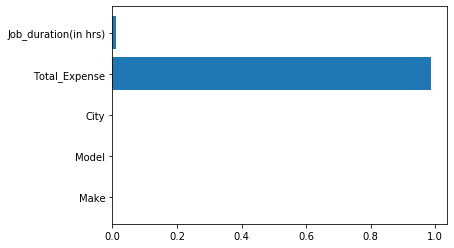

In [621]:
plt.barh(list(X),list(dt.feature_importances_))

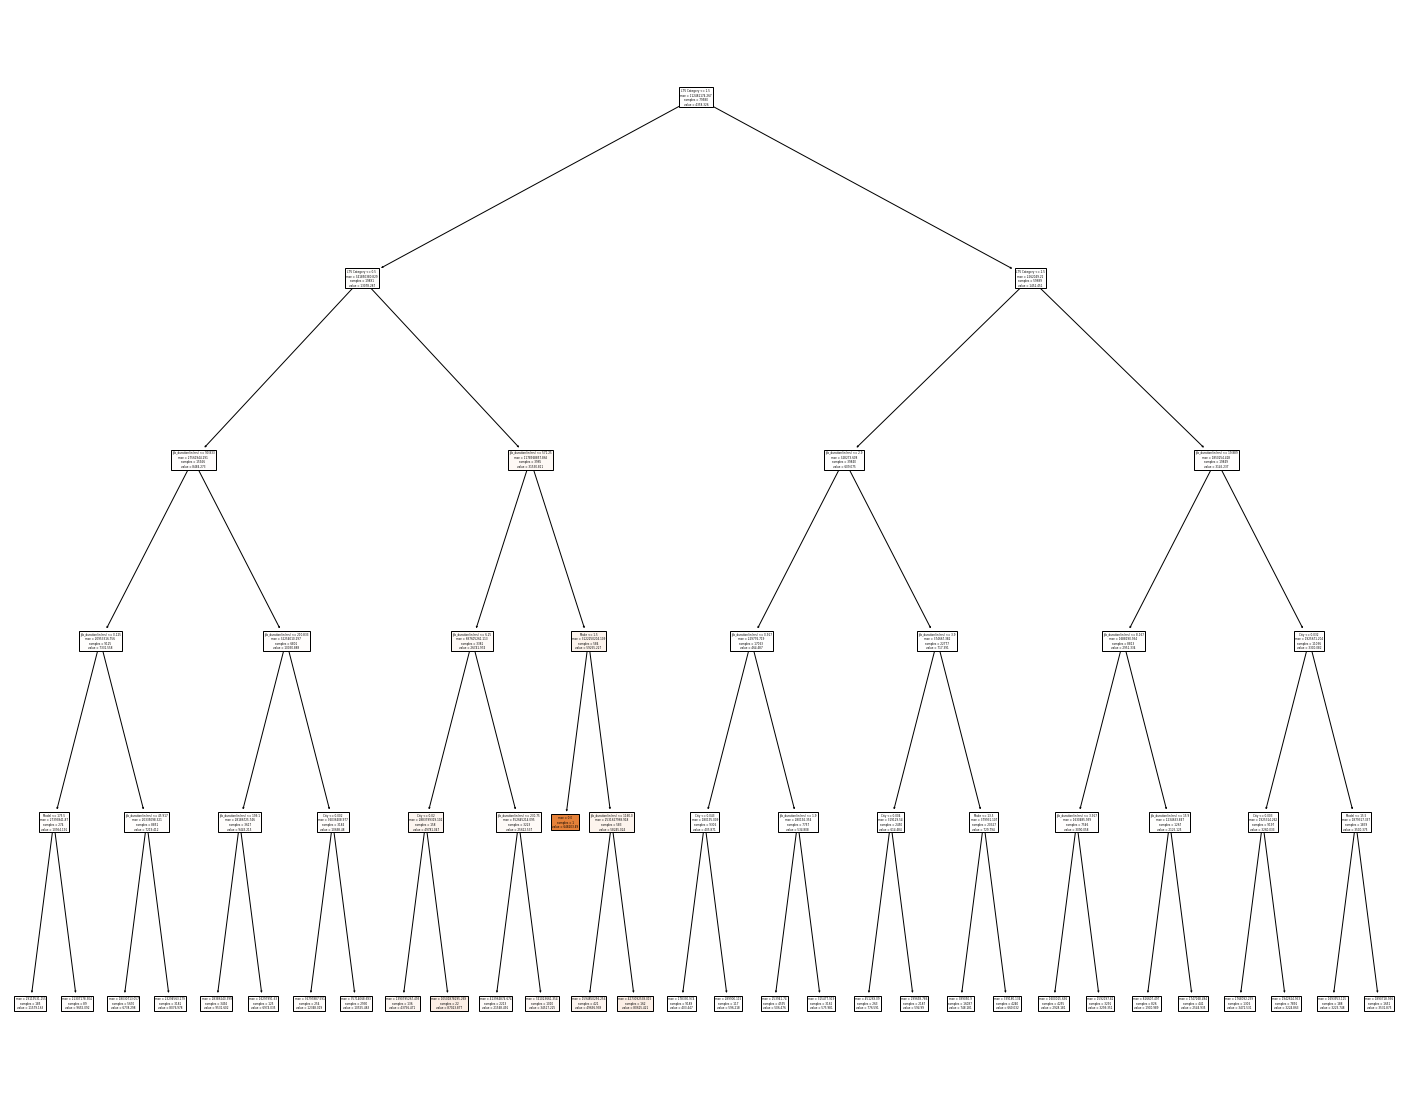

In [683]:
text_representation = tree.export_text(dt)
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=X.columns,  
                   class_names='LTV Category',
                   filled=True)

In [449]:
fig.savefig("decistion_tree.jpg")

# Random Forest Classifier


In [630]:
rfc=RandomForestClassifier(criterion='entropy',max_depth=4,random_state=0).fit(X_train,y_train)

In [631]:
y_pred_rfc=rfc.predict(X_test)

In [632]:
print(classification_report(y_test,y_pred_rfc))

              precision    recall  f1-score   support

           0       0.72      0.63      0.67      6811
           1       0.00      0.00      0.00      1720
           2       0.88      1.00      0.94     17003
           3       0.74      0.77      0.75      8572

    accuracy                           0.82     34106
   macro avg       0.59      0.60      0.59     34106
weighted avg       0.77      0.82      0.79     34106



In [633]:
accuracy_score(y_test,y_pred_rfc)

0.8178912801266639

<BarContainer object of 5 artists>

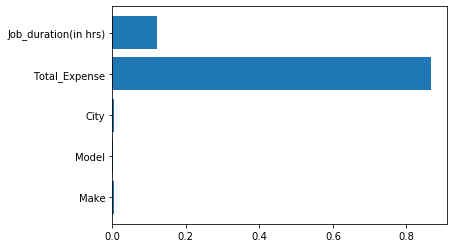

In [634]:
plt.barh(list(X),list(rfc.feature_importances_))

In [635]:
score=cross_val_score(estimator=rfc,X=X,y=y,cv=5)

In [636]:
score.mean()

0.790387325377874

# XgBoost Classifier

In [424]:
xgb=XGBClassifier()
xgb.fit(X_train,y_train)
y_pred_xgb=xgb.predict(X_test)
accuracy_score(y_test,y_pred_xgb)
print(classification_report(y_test,y_pred_xgb))


              precision    recall  f1-score   support

           0       0.85      0.76      0.80      6811
           1       0.93      0.55      0.69      1720
           2       0.94      0.99      0.96     17003
           3       0.81      0.86      0.84      8572

    accuracy                           0.89     34106
   macro avg       0.88      0.79      0.82     34106
weighted avg       0.89      0.89      0.88     34106



In [206]:
scores_xgb=cross_val_score(estimator=xgb,X=X,y=y,cv=5)
scores_xgb.mean()

0.8095449914258758

# Regression

In [637]:
X=df2.drop(["Customer No.","LTV","Total_Expense","Invoice No"],1)
y=df2["Total_Expense"]

In [638]:
X.columns

Index(['Make', 'Model', 'City', 'Job_duration(in hrs)', 'LTV Category'], dtype='object')

In [639]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.3,random_state=0)

# Linear Regression

In [640]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression().fit(X_train,y_train)
y_pred = lr.predict(X_test)

print('Train Score:', lr.score(X_train, y_train))
print("Test Score:", r2_score(y_test, y_pred))

Train Score: 0.13686417525219263
Test Score: 0.13482681396143859


# Random Forest Regressor

In [641]:
X.columns

Index(['Make', 'Model', 'City', 'Job_duration(in hrs)', 'LTV Category'], dtype='object')

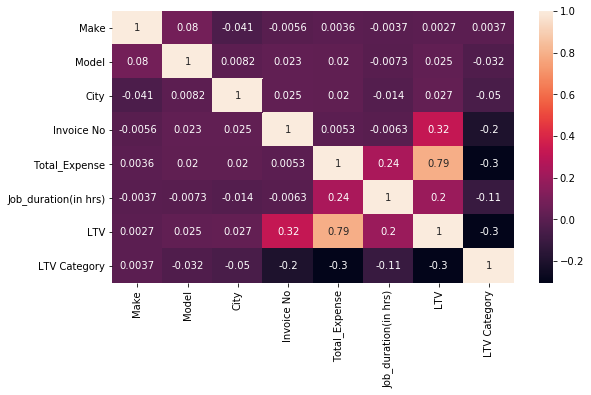

In [642]:
plt.figure(figsize=(9,5))
sns.heatmap(df2.corr(),annot=True)

In [672]:
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor(random_state=0, max_depth=5).fit(X_train,y_train)
y_pred = dt.predict(X_test)

r2_score(y_test, y_pred)
print("Training Score",dt.score(X_train,y_train)

0.5048647467775974

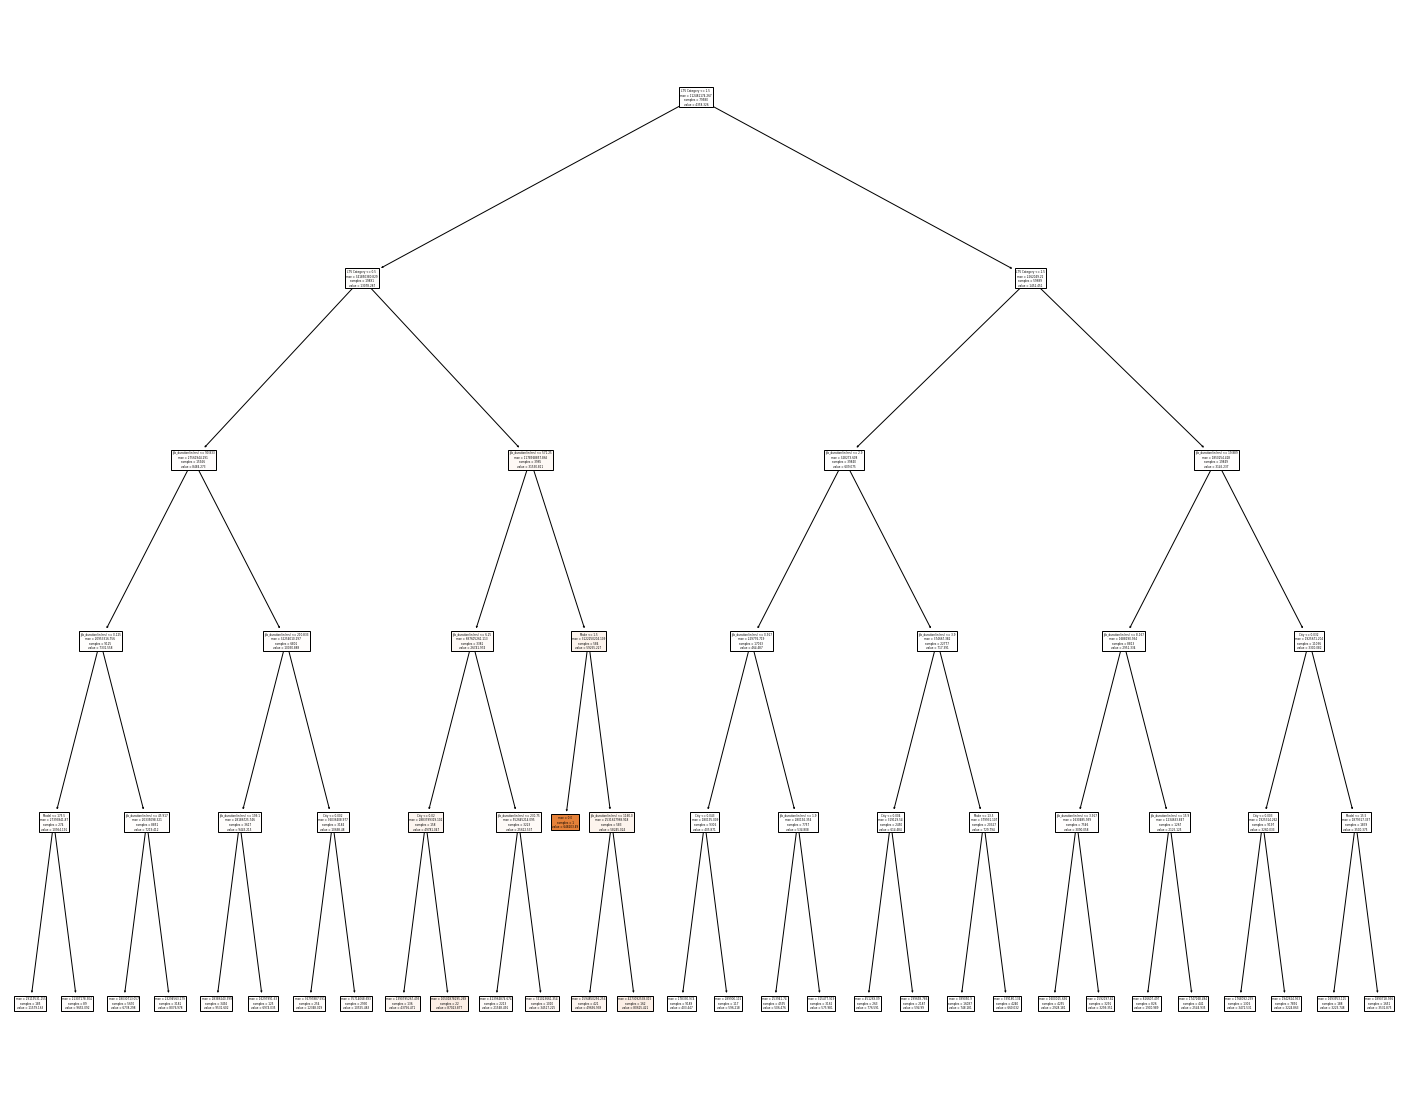

In [661]:
text_representation = tree.export_text(dt)
with open("decistion_tree.log", "w") as fout:
    fout.write(text_representation)
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, feature_names=X.columns,  
                   class_names='Total_Expense',
                   filled=True)

<BarContainer object of 5 artists>

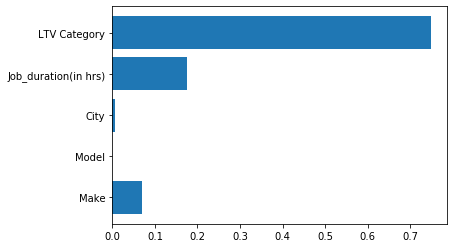

In [663]:
plt.barh(list(X),list(dt.feature_importances_))

In [668]:
from sklearn.ensemble import RandomForestRegressor
rfr = RandomForestRegressor(n_estimators=500,random_state=0,).fit(X_train, y_train)

y_pred = rfr.predict(X_test)

r2_score(y_test,y_pred)


0.5207440580935947

In [673]:
X.columns

Index(['Make', 'Model', 'City', 'Job_duration(in hrs)', 'LTV Category'], dtype='object')

In [687]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from xgboost import XGBRegressor

xgbre = XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgbre.fit(X_train,y_train)
y_pred = xgbre.predict(X_test)
xgbre.score(X_train,y_train)
xgbre.score(X_test,y_test)

from sklearn.metrics import r2_score
r2_score(y_test, y_pred)

0.513532154419592

In [694]:
from sklearn.ensemble import StackingRegressor
from sklearn.metrics import mean_squared_error
models = [("xgb",XGBRegressor()),('rf',RandomForestRegressor())]
stack = StackingRegressor(models).fit(X_train,y_train)
y_pred = stack.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

7100.155546774627

In [699]:
from sklearn.svm import LinearSVR
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingRegressor

estimators = [
    ('rf', RandomForestRegressor(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVR(random_state=42)))
]
reg = StackingRegressor(
    estimators=estimators, final_estimator=XGBRegressor()
).fit(X_train,y_train)
y_pred = reg.predict(X_test)

mean_squared_error(y_test, y_pred, squared=False)

8113.938243312189